# Automated Feature Discovery, complete production workflow

Authors: Joao Gomes, Chandler McCann  
Date: 1/8/2023

This notebook outlines a repeatable framework for end-to-end production machine learning. It includes time-aware feature engineering across multiple tables, training dataset creation, model development, and production deployment.

### Problem framing

It is common to build training data from multiple sources, but this process can be time consuming and error prone, especially when you need to create many time-aware features.

- Event based data is present in every vertical. For example, customer transactions in retail or banking, medical visits, or production line data in manufacturing.
- Summarizing this information at the parent (Entity) level is necessary for most classification and regression use cases. For example, if you are predicting fraud, churn, or propensity to purchase something, you will likely want summary statistics of a customers transactions over a historical window.

This raises many practical considerations as a data scientist: How far back in time is relevant for training? Within that training period, which windows are appropriate for features? 30 days? 15? 7? Further, which datasets and variables should you consider for feature engineering? Answering these conceptual questions requires domain expertise or interaction with business SMEs. 

In practice, especially at the MVP stage, it is common to limit the feature space you explore to what's been created previously or add a few new ideas from domain expertise.
- Feature stores can be helpful to quickly try features which were useful in a previous use case, but it is a strong assumption that previously generated lagged features will adapt well across all future use cases.
- There are almost always important interactions you haven't evaluated or thought of. 

Multiple tactical challenges arise as well. Some of the more common ones are:
- Time formats are inconsistent between datasets (e.g., minutes vs. days), and need to be handled correctly to avoid target leakage.
- Encoding text and categorical data aggregates over varying time horizons across tables is generally painful and prone to error.
- Creating a hardened data pipeline for production can take weeks depending on the complexity.
- A subtle wrinkle is that short and long-term effects of data matter, particularly with customers/patients/humans, and those effects change over time. It's hard to know apriori which lagged features to create.
- When data drifts and behavior changes, you very well may need entirely new features post-deployment, and the process starts all over.

All of these challenges inject risk into your MVP process. The best case scenario is historical features capture signal in your new use case, and further exploration to new datasets is limited when the model is "good enough".  The worst case scenario is you determine the use case isn't worth pursuing, as your features don't capture the new signal.  You often end up in the middle, struggling to know how to improve a model you are sure can be better. 

What if you could radically collapse the cycle time to explore and discover features across any relevant dataset?

This notebook provides a template to:

1. Load data into Snowflake and register with DataRobot's AI Catalog.
2. Configure and build time aware features across multiple historical time-windows and datasets using Snowflake (applicable to any database).
3. Build and evaluate multiple feature engineering approaches and algorithms for all data types.
4. Extract insights and identify the best feature engineering and modeling pipeline.
5. Test predictions locally.
6. Deploy the best performing model and all feature engineering in a Docker container, and expose a REST API.
7. Score from Snowflake and write predictions back to Snowflake.

For more information about the Python client, reference the [documentation](https://docs.datarobot.com/en/docs/api/api-quickstart/index.html).

## Setup

### Import libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt
from IPython.display import display, HTML
from utils import prepare_demo_tables_in_db

### Connect to DataRobot

In [2]:
# Authenticate in to your DataRobot instance
import datarobot as dr # Requires version 3.0 or later 
dr.__version__


# use your DataRobot API Credentials
DATAROBOT_API_TOKEN = 'YOURAPITOKEN'
DATAROBOT_ENDPOINT = 'YOUR_DATAROBOT_BASE_URL'

client =dr.Client(
    token=DATAROBOT_API_TOKEN, 
    endpoint=DATAROBOT_ENDPOINT,
    user_agent_suffix='AIA-AE-AFD-9'
)

dr.client._global_client = client

'3.0.2'

## Predict defaults from customer transactions, profiles, and default data

The data used in this notebook is from anonymized historical loan application data, and used to predict if a customer will default on their loan or not. There are three tables: 
    
- `LC_Train` - Contains a customer ID, the date, and whether the loan defaulted or not (the target variable). This is the **primary dataset**.

- `LC_Profile` - Contains loan level data (interest rate, purpose for the loan, etc.), and customer info (address, employment, etc.). This is a **secondary dataset**.

- `LC_Transactions` - Has multiple transactions per customer across accounts, transaction type, and time. This is a **secondary dataset**.
    
- `LC Test` - The validation set version of `LC_Train`. This used for showing the deployment pipeline on new data, and is our **primary dataset for an example deployment**.

You  want to create a training dataset of one record per customer, with relevant time-based features from their transactions as well as non-time based features from their profile. The data is in a public S3 bucket and will be transferred to your Snowflake instance.

## Create Governed Datasets for Training 

### Import from S3 to Snowflake
Update the fields below with your Snowflake information to read in each file from S3 and create new tables in your Snowflake instance.

In [3]:
# Fill out the credentials for your instance. You will need write access to a database. 
db_user = 'your_username' # Username to access snowflake database
db_password = 'your_password' # Uassword 
account = 'eg:datarobotap_partner.ap-southeast-2' # Snowflake account identifier, can be found in the db_url
db = 'YOUR_DB_NAME' # Database to Write_To, "Snowflake Demo DB" in our example below
warehouse = 'YOUR_WAREHOUSE' # Warehouse 
schema = 'YOUR_SCHEMA' 

db_url = 'jdbc:snowflake://{account}.snowflakecomputing.com/?warehouse={warehouse}&db={db}'.format(
    account = account,
    db = db,
    warehouse = warehouse
)

In [4]:
# The cell below writes the tables to your instance
response = prepare_demo_tables_in_db(
    db_user = db_user,                        
    db_password = db_password,                
    account = account,                        
    db = db,                                  
    warehouse = warehouse,                     
    schema = schema
)

******************************
table: LC_PROFILE


,CustomerID,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,purpose,zip_code,addr_state
0,C900002437,4000,4000,60 months,7.29%,79.76,A,A4,Time Warner Cable,10+ years,MORTGAGE,50000.0,not verified,medical,766xx,TX
1,C900006073,16000,16000,60 months,18.25%,408.48,F,F1,Ottawa University,< 1 year,RENT,39216.0,not verified,debt_consolidation,660xx,KS
2,C900007834,8700,8700,36 months,7.88%,272.15,A,A5,Kennedy Wilson,4 years,RENT,65000.0,not verified,credit_card,916xx,CA
3,C900001691,18000,18000,60 months,11.49%,395.78,B,B4,TOWN OF PLATTEKILL,10+ years,MORTGAGE,57500.0,not verified,debt_consolidation,124xx,NY
4,C900002594,16000,16000,36 months,11.83%,530.15,B,B3,Belmont Correctional,10+ years,MORTGAGE,50004.0,VERIFIED - income,debt_consolidation,439xx,OH


info for  LC_PROFILE
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           10000 non-null  object 
 1   loan_amnt            10000 non-null  int64  
 2   funded_amnt          10000 non-null  int64  
 3   term                 10000 non-null  object 
 4   int_rate             10000 non-null  object 
 5   installment          10000 non-null  float64
 6   grade                10000 non-null  object 
 7   sub_grade            10000 non-null  object 
 8   emp_title            9408 non-null   object 
 9   emp_length           9741 non-null   object 
 10  home_ownership       10000 non-null  object 
 11  annual_inc           9999 non-null   float64
 12  verification_status  10000 non-null  object 
 13  purpose              10000 non-null  object 
 14  zip_code             10000 non-null  object 
 15  addr_state      

,CustomerID,AccountID,Date,Amount,Description
0,C900000001,A484993284,2016-07-21,79.42,alcohol
1,C900000001,A651639077,2016-07-31,37.87,government charges
2,C900000002,A355056969,2016-06-29,4.92,amortisation
3,C900000002,A355056969,2016-07-01,18.97,interest on purchases
4,C900000002,A355056969,2016-07-02,29.06,charity


info for  LC_TRANSACTIONS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412459 entries, 0 to 412458
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   CustomerID   412459 non-null  object 
 1   AccountID    412459 non-null  object 
 2   Date         411129 non-null  object 
 3   Amount       403750 non-null  float64
 4   Description  412441 non-null  object 
dtypes: float64(1), object(4)
memory usage: 15.7+ MB
None
writing LC_TRANSACTIONS to snowflake from:  https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/LC_transactions.csv
******************************
table: LC_TRAIN


,CustomerID,BadLoan,date
0,C900000001,No,2016-08-06
1,C900000002,No,2016-07-27
2,C900000003,No,2016-07-06
3,C900000004,No,2016-08-26
4,C900000005,No,2016-08-28


info for  LC_TRAIN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9499 entries, 0 to 9498
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CustomerID  9499 non-null   object
 1   BadLoan     9499 non-null   object
 2   date        9499 non-null   object
dtypes: object(3)
memory usage: 222.8+ KB
None
writing LC_TRAIN to snowflake from:  https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/LC_train.csv
******************************
table: LC_TEST


,CustomerID,BadLoan,date
0,C900009501,No,2016-08-03
1,C900009502,No,2016-07-23
2,C900009503,Yes,2016-08-29
3,C900009504,Yes,2016-07-01
4,C900009505,No,2016-08-13


info for  LC_TEST
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CustomerID  500 non-null    object
 1   BadLoan     500 non-null    object
 2   date        500 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB
None
writing LC_TEST to snowflake from:  https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/LC_test.csv


### Create a data store in AI Catalog

To register the data with DataRobot, you will need to authorize DataRobot to access Snowflake.  To do so, create credentials authorizing AI Catalog access to this new database, and pass the JDBC driver information for Snowflake to create a Datastore in the AI Catalog. When a Datastore (the Snowflake database) is registered, the tables you want can be accessed, and version history metadata can be associated to any downstream project, model, deployment or prediction, going forward.

For more information, reference the DataRobot documentation for [integrating with a Snowflake database](https://docs.datarobot.com/en/docs/platform/integrations/snowflake/sf-project-creation.html#pull-snowflake-jdbc-sql).

In [5]:
# Find the JDBC driver ID from name
# Can be skipped if you have the ID--code is shown here for completeness
for d in dr.DataDriver.list():
    if d.canonical_name in 'Snowflake (3.13.9 - recommended)':
        print((d.id, d.canonical_name))

('626bae0a98b54f9ba70b4122', 'Snowflake (3.13.9 - recommended)')


In [6]:
# Create a data store 
# This step can be skipped if you have the data store ID--code is shown here for completeness
data_store = dr.DataStore.create(
        data_store_type='jdbc',
        canonical_name='Snowflake Demo DB',
        driver_id='626bae0a98b54f9ba70b4122',
        jdbc_url= db_url
    )
data_store.test(username=db_user, password=db_password)

{'message': 'Connection successful'}

Create and store credentials to allow the AI Catalog access to this database. These can be found in the **Data Connections** tab under your profile in DataRobot.  

In [7]:
cred = dr.Credential.create_basic(
        name='test_cred',
        user=db_user,
        password=db_password,
    )

### Create versioned datasets from your data store in Snowflake

After registering the Snowflake DB in AI Catalog, you can use the DataRobot API to access Snowflake tables.

To facilitate data access, DataRobot defines the following entities:

Data store: The system with the data in this case Snowflake. You created this in the previous step.  
Data source: The query or table with the data. In this case, we have three: `LC_PROFILE`, `LC_TRAIN` and `LC_TRANSACTIONS`. We'll set up `LC_TEST` later.  
Dataset: A registered dataset for ML projects, which is a query or pull from the parent data source.  

This structure allows us to track versions of data used for modeling and predictions. For each table, you will:
- Create a new data source from a query of the table in the Snowflake DB.
- Create a dataset, which is a versioned extract from that table (data source). You will use a dynamic extract policy here, but you can set up various snap-shotting policies as well.

For completeness, we explicitly create each dataset with individual code blocks. In practice, you can easily create a helper function for this. If you have dataset id's in AI Catalog, you can proceed to project creation

In [8]:
# Create the target dataset 
# Define the query
params = dr.DataSourceParameters(
        data_store_id=data_store.id,
        query='SELECT * FROM {db}.{schema}.LC_TRAIN'.format(db=db, schema=schema)
    )
# Establish the data source    
data_source = dr.DataSource.create(
        data_source_type='jdbc',
        canonical_name='snowflake_lc_train',
        params=params
    )
# Create an individual dataset
# New datasets can be made from the same data source in the future, with completely new unique identifiers for other projects 
dataset_target = dr.Dataset.create_from_data_source(data_source.id, 
                                                         do_snapshot=False, # Create a dynamic dataset from the datastore
                                                         credential_id=cred.credential_id)

# One way to take a look at the data
# dataset_target.get_as_dataframe()

Use the snippet below to create the profile dataset.

In [9]:
params = dr.DataSourceParameters(
        data_store_id=data_store.id,
        query='SELECT * FROM {db}.{schema}.LC_PROFILE'.format(db=db, schema=schema)
    )
data_source = dr.DataSource.create(
        data_source_type='jdbc',
        canonical_name='snowflake_lc_profile',
        params=params
    )
dataset_profile = dr.Dataset.create_from_data_source(data_source.id, 
                                                         do_snapshot=False, 
                                                         credential_id=cred.credential_id)
# One way to quickly jump to the DataRobot GUI
# dataset_profile.open_in_browser()

Use the snippet below to create the transactions dataset.

In [10]:
params = dr.DataSourceParameters(
        data_store_id=data_store.id,
        query='SELECT * FROM {db}.{schema}.LC_TRANSACTIONS'.format(db=db, schema=schema)
    )
data_source = dr.DataSource.create(
        data_source_type='jdbc',
        canonical_name='snowflake_lc_transactions',
        params=params
    )
dataset_trans = dr.Dataset.create_from_data_source(data_source.id, 
                                                         do_snapshot=False, 
                                                         credential_id=cred.credential_id)

HTML(f'''<div style="text-aligh:center;padding:.75rem;"> 
    <a href="{dataset_trans.get_uri()}" target="_blank" style="background-color:#5371BF;color:white;padding:.66rem .75rem;border-radius:5px;cursor: pointer;">Open Dataset in DataRobot</a>
</div>''')

You can extract metadata and statistics on the data that has been registered in AI Catalog.

In [11]:
features_from_dr = dataset_trans.get_all_features()

pd.DataFrame(
    [
        {
            "Feature Name": f.name,
            "Feature Type": f.feature_type,
            "Unique Count": f.unique_count,
            "NA Count": f.na_count,
            "Min": f.min,
            "Mean": f.mean,
            "Median": f.median,
            "Max": f.max,
            
        }
        for f in features_from_dr
    ]
)

,Feature Name,Feature Type,Unique Count,NA Count,Min,Mean,Median,Max
0,AccountID,Text,28205,0,None,None,None,None
1,Amount,Numeric,18057,8709,0.01,3877.76,37,41899723
2,CustomerID,Categorical,9311,0,None,None,None,None
3,Date,Date,87,1330,2016-06-01,2016-07-14,2016-07-14,2016-08-26
4,Description,Categorical,153,18,None,None,None,None


## Configure Time-aware Feature Engineering

To set up a Feature Discovery project from the API, you want to create a DataRobot Project object so you can define all of the relationships between datasets.

- Create the project with the primary dataset (this will always have your target variable), provide database credentials, and a project name.
- Configure which feature engineering operators should be explored during [Feature Discovery](https://docs.datarobot.com/en/docs/data/transform-data/feature-discovery/fd-gen.html) across datasets.

### Create a DataRobot project

In [12]:
project = dr.Project.create_from_dataset(dataset_target.id, #unique ID of the target dataset we just created
                                         credential_id=cred.credential_id, # don't forget the snowflake credentials
                                         project_name='Snowflake Lending Club API')

Store your Feature Discovery settings as a variable, which can be passed to a project's Advanced Options before you start building features and modeling.  The time windows to derive these is defined in later cells. This is very useful if you want to constrain or experiment certain feature derivation types. Importantly, this list uses only non-UDF features, which can be exported and executed via Spark SQL. 

In [13]:
# Define the type of feature engineering you want to explore
feature_discovery_settings_no_udf = [{'name': 'enable_days_from_prediction_point', 'value': True},
                                     {'name': 'enable_hour', 'value': True},
                                     {'name': 'enable_categorical_num_unique', 'value': True},
                                     {'name': 'enable_categorical_statistics', 'value': False},
                                     {'name': 'enable_numeric_minimum', 'value': True},
                                     {'name': 'enable_token_counts', 'value': False},
                                     {'name': 'enable_latest_value', 'value': True},
                                     {'name': 'enable_numeric_standard_deviation', 'value': True},
                                     {'name': 'enable_numeric_skewness', 'value': False},
                                     {'name': 'enable_day_of_week', 'value': True},
                                     {'name': 'enable_entropy', 'value': False},
                                     {'name': 'enable_numeric_median', 'value': True},
                                     {'name': 'enable_word_count', 'value': False},
                                     {'name': 'enable_pairwise_time_difference', 'value': True},
                                     {'name': 'enable_days_since_previous_event', 'value': True},
                                     {'name': 'enable_numeric_maximum', 'value': True},
                                     {'name': 'enable_numeric_kurtosis', 'value': False},
                                     {'name': 'enable_most_frequent', 'value': False},
                                     {'name': 'enable_day', 'value': True},
                                     {'name': 'enable_numeric_average', 'value': True},
                                     {'name': 'enable_summarized_counts', 'value': False},
                                     {'name': 'enable_missing_count', 'value': True},
                                     {'name': 'enable_record_count', 'value': True},
                                     {'name': 'enable_numeric_sum', 'value': True}]

### Define the relationships between datasets 

Define relationships between datasets for joins and the primary time field to ensure correct time-awareness for feature engineering. DataRobot will automatically handle variations in time data between datasets (e.g. minutes--> hours). The following snippet defines how each dataset relates to each other, and how far back in time to derive features.

- Specify the relationships (join-keys) between the secondary and primary datasets, and the Feature Derivation Window (FDW) to explore. 
- You can have multiple relationships between datasets (e.g., a join on customer ID and a separate join on Products to look at aggregate behavior at the product vs. customer level).    
- The 'primary_temporal_key' will be the date-time field used to respect the prediction point (defined at project start).
- You can define multiple time windows to explore long and short-term effects.   
- DataRobot will automatically recognize data is coming from Snowflake, and push-down compute to Snowflake to accelerate feature engineering.
- For further reading, reference the documentation for [Feature Discovery](https://docs.datarobot.com/en/docs/data/transform-data/feature-discovery/fd-overview.html) and [time series](https://docs.datarobot.com/en/docs/data/transform-data/feature-discovery/fd-time.html) applications.

In [14]:
########################### Define the datasets for feature engineering ###############################
# Store the dataset AI Catalog IDs as a variable for simplicity
profile_catalog_id = dataset_profile.id
profile_catalog_version_id = dataset_profile.version_id

transac_catalog_id = dataset_trans.id
transac_catalog_version_id = dataset_trans.version_id

# Define the secondary datasets
# Defines the dataset identifier, temporal key, and snapshot policy for the secondary datasets
profile_dataset_definition = dr.DatasetDefinition(
    identifier='profile',
    catalog_id=profile_catalog_id,
    catalog_version_id=profile_catalog_version_id,
    snapshot_policy='dynamic'
    # feature_list_id='607cd4d362fc0cc7c8bc04cd', can be used to set a different feature_list
)

transaction_dataset_definition = dr.DatasetDefinition(
    identifier='transactions',
    catalog_id=transac_catalog_id,
    catalog_version_id=transac_catalog_version_id,
    primary_temporal_key='Date',
    snapshot_policy='dynamic'
)

########################## Define the join relationships and Feature Derivation Windows #########################

profile_transaction_relationship = dr.Relationship(
    dataset1_identifier='profile', #join profile
    dataset2_identifier='transactions', #to transactions
    dataset1_keys=['CustomerID'], # on CustomerID
    dataset2_keys=['CustomerID']
)
# You do not need to specify dataset1Identifier when joining with the primary dataset
primary_profile_relationship = dr.Relationship( #join primary dataset
    dataset2_identifier='profile', # to profile
    dataset1_keys=['CustomerID'], #on CustomerID
    dataset2_keys=['CustomerID'],
    #feature_derivation_window_start=-14,
    #feature_derivation_window_end=-1,
    #feature_derivation_window_time_unit='DAY',
    feature_derivation_windows=[{'start': -7, 'end': -1, 'unit': 'DAY'}, 
                                {'start': -14, 'end': -1, 'unit': 'DAY'}, 
                                {'start': -30, 'end': -1, 'unit': 'DAY'}], #example of multiple FDW
    prediction_point_rounding=1,
    prediction_point_rounding_time_unit='DAY'
)
# Store datasets and relationships as a list for config settings
dataset_definitions = [profile_dataset_definition, transaction_dataset_definition]
relationships = [primary_profile_relationship, profile_transaction_relationship]

# Create the relationships configuration to define the connection between the datasets
# This will be passed to the DataRobot project configuration for Autopilot
relationship_config = dr.RelationshipsConfiguration.create(
    dataset_definitions=dataset_definitions, 
    relationships=relationships,
    feature_discovery_settings = feature_discovery_settings_no_udf)

The resulting configuration will appear in DataRobot as seen below. The following section of code will activate the feature engineering displayed in the top row

<img src="img/FD_Config.png" width="800">

## Build models

So far you have:

- Registered your datasets in the AI Catalog and defined their relationships
- Defined the types of feature engineering and time frames to explore

This configuration is stored in time and can be reused. To start modeling, you want to:

- pass the newly defined relationship config from above
- since you are using dynamic datasets, you must pass your credentials as each primary dataset extract triggers a query of the secondary datasets
- note: The first line toggles Supervised Feature Reduction (SFR). The Feature Discovery step creates and explores a wide range of features (can be hundreds or thousands), and SFR will intelligently weed out low-information features. The remaining features will be formed into one dataset of candidate features in your project (which you will further reduce)

Once complete, you will initiate Autopilot with DataRobot to build models.

In [15]:
# SFR default is True, shown here as an example of how to set SFR using the API
advanced_options = dr.AdvancedOptions(
    feature_discovery_supervised_feature_reduction=True) 


# partitioning_spec = dr.DatetimePartitioningSpecification('date') 
# You can use prediction point instead

project.analyze_and_model(
    target='BadLoan', 
    relationships_configuration_id=relationship_config.id,
    credentials=[{
                 # only needed for snowflake dynamic datasets 
                 'credentialId': cred.credential_id,
                 'catalogVersionId': dataset_profile.version_id
                },
                { 
                 'credentialId': cred.credential_id,
                 'catalogVersionId': dataset_trans.version_id
                }],
    feature_engineering_prediction_point='date', # The prediction point is defined here. This maps to the 'primary_temporal_key' in the Relationship Config above
    advanced_options=advanced_options)

project.set_worker_count(-1) # Use all available workers

project.wait_for_autopilot()

In progress: 9, queued: 0 (waited: 0s)
In progress: 9, queued: 0 (waited: 1s)
In progress: 9, queued: 0 (waited: 2s)
In progress: 9, queued: 0 (waited: 3s)
In progress: 9, queued: 0 (waited: 5s)
In progress: 9, queued: 0 (waited: 7s)
In progress: 9, queued: 0 (waited: 11s)
In progress: 9, queued: 0 (waited: 19s)
In progress: 8, queued: 0 (waited: 32s)
In progress: 2, queued: 0 (waited: 53s)
In progress: 2, queued: 0 (waited: 74s)
In progress: 1, queued: 0 (waited: 95s)
In progress: 1, queued: 0 (waited: 116s)
In progress: 1, queued: 0 (waited: 137s)
In progress: 1, queued: 0 (waited: 158s)
In progress: 1, queued: 0 (waited: 179s)
In progress: 1, queued: 0 (waited: 199s)
In progress: 1, queued: 0 (waited: 220s)
In progress: 1, queued: 0 (waited: 241s)
In progress: 1, queued: 0 (waited: 262s)
In progress: 1, queued: 0 (waited: 283s)
In progress: 1, queued: 0 (waited: 304s)
In progress: 1, queued: 0 (waited: 325s)
In progress: 1, queued: 0 (waited: 345s)
In progress: 1, queued: 0 (waited:

## Model Selection
### Identify the top performing model

Below is a baseline approach to extract insights from the model object, and build a deployment pipeline. You will:
- Find the model that is recommended for deployment. This is based on the lowest error of your project metric for cross-validation.
- Plot the top ten features used in the recommended model.
- Observe how many of the features used have been generated by DataRobot automatically.

Note that any insight in the DataRobot app can be accessed via the API, and model analysis is limited here to focus on the end-to-end pipeline in this tutorial


Reference the DataRobot documentation for more information on [feature aggregations](https://docs.datarobot.com/en/docs/data/transform-data/feature-discovery/fd-gen.html#feature-aggregations).

In [16]:
# The model used for predictions
model = project.recommended_model()

display(
    HTML(f'''<div style="text-aligh:center;padding:.75rem;"> 
    <a href="{model.get_uri()}" target="_blank" style="background-color:#5371BF;color:white;padding:.66rem .75rem;border-radius:5px;cursor: pointer;">{model.model_type}</a>
</div>''')
)
print("The top performing model was", model.model_type)
print("Feature list used:", model.featurelist_name,", containing", len(model.get_features_used()), "features")
print("*"*10)

pd.DataFrame(model.metrics)

The top performing model was Light Gradient Boosted Trees Classifier with Early Stopping
Feature list used: DR Reduced Features M19 , containing 41 features
**********


,AUC,Area Under PR Curve,FVE Binomial,Gini Norm,Kolmogorov-Smirnov,LogLoss,Max MCC,RMSE,Rate@Top10%,Rate@Top5%,Rate@TopTenth%
validation,0.803830,0.46617,0.212090,0.607660,0.490740,0.284530,0.38021,0.286280,0.453950,0.631580,1.0
crossValidation,0.804238,0.45420,0.207666,0.608476,0.495658,0.286126,0.37724,0.287538,0.457896,0.605264,0.9
holdout,0.832140,0.49662,0.243140,0.664280,0.537300,0.273810,0.42922,0.281980,0.510530,0.705260,0.5
training,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
backtestingScores,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
backtesting,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Note that the top model was trained on the `DR Reduced Features M19` feature list. This is the result of built-in feature reduction that removes features with correlated permutation importance for the top performing model from Autopilot. This was reduced from Model 19 (M19), which by default used the `Informative Features` feature list. 

You also enabled Supervised Feature Reduction in advanced settings, which occurs after target selection but prior to running any models.  In terms of total features, so far you have gone from 24 Features in your original three tables, to:

138 explored features (from the Feature Discovery tab)  
75 features that progressed passed supervised feature reduction   
81 Informative Features (including 6 from the initial data set)  
41 in DR Reduced Features M19    

You can imagine how the feature space grows in size with additional data and the time-savings created by iterating quickly on datasets.

You can quickly compare the performance between the baseline (Informative Features) and reduced feature lists

In [102]:
print('Best performing blueprint LogLoss (5 fold CV at 64% of training data, Informative Features):', dr.Model.get(project.id, '63bb034a1f65cbf40f2e2031').metrics['LogLoss']['crossValidation'])
print('Best performing blueprint LogLoss (5 fold CV at 64% of training data, DR Reduced Features):', dr.Model.get(project.id, '63bb0458d98255aeb86ca839').metrics['LogLoss']['crossValidation'])

Best performing blueprint LogLoss (5 fold CV at 64% of training data, Informative Features): 0.289138
Best performing blueprint LogLoss (5 fold CV at 64% of training data, DR Reduced Features): 0.288886


### Evaluate features

In the following cell you will plot permutation importance of the top ten features. 

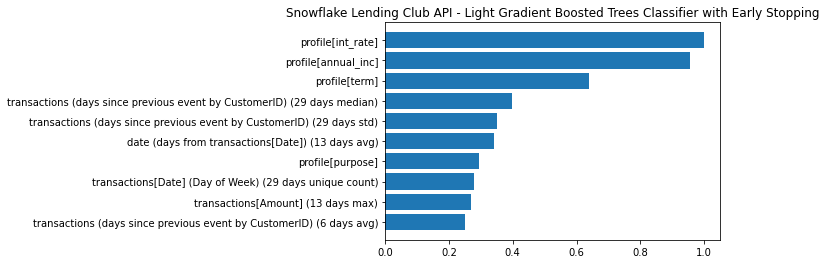

In [19]:
# Plot permutation based importance (Feature Impact)
plt_data = pd.DataFrame.from_records(model.get_or_request_feature_impact()).sort_values('impactNormalized', ascending=True).tail(10) #top 10, can remove to see all features
ax = plt.barh(plt_data['featureName'], plt_data['impactNormalized'])
plt.title(f"{project.project_name} - {model.model_type}")
plt.show()

Note how many of the top 10 features were derived from Feature Discovery and their diversity. Features such as the standard deviation of the number of days between transcations at the CustomerID level, over a 29 day window (shown below), capturing the variation in monthly spending behavior, provide signal and also could be prone to error in SQL or python.

Notice that the 29 (not 30) days comes from how you defined the Feature Derivation window as 30 days up to 1 day from the prediction point, in the primary_profile_relationship. As you move beyond your MVP model and want to experiment with more datasets and historical time horizons, it can often be beneficial to create multiple projects programatically to evaluate Feature Derivation Window combinations vs trying every combination in one project. This step-wise approach to adding data can simplify feature selection and also helps in determening your ultimate feature set. There is no silver bullet, but our [AI Accelerator with ML Flow](https://community.datarobot.com/t5/ai-accelerators/use-mlflow-with-datarobot-api-for-tracking-experimentation/m-p/15912#M7) can assist with evaluation.



<img src="img/lineage_complex.png" width="800">

It's also possible to view the feature lineage via the api. 

In [103]:
#function to take in a feature from a project and return the lineagae
def get_lineage(proj,fname): 
    lineage = dr.Feature.get(project.id, fname)
    feat_eng = dr.models.FeatureLineage.get(project.id, lineage.feature_lineage_id).steps
    
    return pd.DataFrame.from_dict(feat_eng, orient='columns')

get_lineage(project, 'profile[purpose]')
#transactions (days since previous event by CustomerID) (29 days std)

,id,step_type,parents,name,data_type,is_time_aware,join_info,catalog_id,catalog_version_id,columns
0,0,generatedColumn,[],profile[purpose],Categorical,NaN,NaN,NaN,NaN,NaN
1,1,join,[0],NaN,NaN,False,"{'join_type': 'left', 'left_table': {'datasteps': [3], 'columns': ['CustomerID']}, 'right_table': {'datasteps': [2], 'columns': ['CustomerID']}}",NaN,NaN,NaN
2,2,data,[1],profile,NaN,NaN,NaN,63bafe3a59d6375c9ee0bced,63bafe3a59d6375c9ee0bcee,"[{'name': 'purpose', 'data_type': 'Categorical', 'is_input': True, 'is_cutoff': False}, {'name': 'CustomerID', 'data_type': 'Categorical', 'is_input': False, 'is_cutoff': False}]"
3,3,data,[1],Primary dataset,NaN,NaN,NaN,NaN,NaN,"[{'name': 'CustomerID', 'data_type': 'Categorical', 'is_input': False, 'is_cutoff': False}]"


Finally, let's examine the full diversity of features used in the model we will deploy. The code below presents all features from the `DR Reduced Features M19` feature list, sorted by their normalized permutation importance

In [21]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
plt_data = pd.DataFrame.from_records(model.get_or_request_feature_impact()).sort_values('impactNormalized', ascending=False)
plt_data

,featureName,impactNormalized,impactUnnormalized,redundantWith
0,profile[int_rate],1.000000,0.025971,None
1,profile[annual_inc],0.955103,0.024805,None
2,profile[term],0.638811,0.016591,None
3,transactions (days since previous event by CustomerID) (29 days median),0.396326,0.010293,None
4,transactions (days since previous event by CustomerID) (29 days std),0.351735,0.009135,None
5,date (days from transactions[Date]) (13 days avg),0.342196,0.008887,None
6,profile[purpose],0.293125,0.007613,None
7,transactions[Date] (Day of Week) (29 days unique count),0.279081,0.007248,None
8,transactions[Amount] (13 days max),0.269887,0.007009,None
9,transactions (days since previous event by CustomerID) (6 days avg),0.249275,0.006474,None


As we mentioned in the Problem Framing, you generally may not pursue more complex features beyond what is available in past projects or a feature store, or want to deal with data types like text right away, however, in this case the text feature `Purpose` in the `LC_Profile` table was in the top 10 for adding signal. Further, we disabled numerous feature engineering steps in our Feature Derivation Configuration. The takeaway here is that by leveraging automation we are able to more efficiently progress our MVP and explore relevant features, saving important cycle time in the initial phase of modeling. 

The cell below shows how you can examine a blueprint step in your notebook. In this case, the text processing pipeline of DataRobot is highly efficient and also non-trivial.

In [22]:
print("Feature engineering processes: ", model.blueprint.processes) #quick view of model level feature engineering processes. These can be explored in great detail
print("*"*10)
print("Example explanation of text modeling step: ",model.blueprint.processes[3])
print("*"*10)
print(model.get_model_blueprint_documents()[3].description)

Feature engineering processes:  ['Ordinal encoding of categorical variables', 'Missing Values Imputed', 'Converter for Text Mining', 'Auto-Tuned Word N-Gram Text Modeler using token occurrences', 'Light Gradient Boosted Trees Classifier with Early Stopping']
**********
Example explanation of text modeling step:  Auto-Tuned Word N-Gram Text Modeler using token occurrences
**********
Fit a single-word n-gram model to each text feature in the input dataset, then use the predictions from these models as inputs to an ElasticNet classifier.
Word N-Gram:
A word n-gram model is a special case of n-gram modeling, where the n-gram is a contiguous sequence of n items from a given sequence of text (an “item” is a single word). Word n-gram models first construct a “vocabulary” of all sequences of words in the input dataset and then make a matrix with counts of n-gram occurrences in each row.
Auto-Tuned N-Gram:
Auto-tuned n-grams automatically decide the size of n-gram to use, trying unigrams (or a 

## Configure Your Deployment Pipeline 

Once you decide on a model and set of features, DataRobot will automatically handle time-aware derivation in production with your prediction data. To ensure your training and serving pipelines are correct, you need to define how to add in new data at prediction time. This involves:

- Defining a secondary dataset configuration (the relationships between datasets)
    - Below you 
    - [Reference the documentation](https://docs.datarobot.com/en/docs/data/transform-data/feature-discovery/fd-predict.html#select-a-secondary-dataset-configuration) for more details.
- Creating a dataset for the test data in AI catalog.

In [23]:
# The following steps allow you to use new secondary datasets during prediction
# Get the default config as reference, in an existing project with multiple configurations you should iterate over SecondaryDatasetConfigurations and use "is_default"
# The cell below outputs the format of the training configuration

default_dataset_config = dr.SecondaryDatasetConfigurations.list(project_id=project.id)[0]
config = default_dataset_config.to_dict().copy()
config

{'id': '63bb0026a1d008b60ebafa84',
 'project_id': '63bafedb82f0196b30e19589',
 'config': [{'feature_engineering_graph_id': '63baff65a1d008b60ebafa31',
   'secondary_datasets': [{'identifier': 'transactions',
     'catalog_id': '63bafe804ffb1b5b6cacd976',
     'catalog_version_id': '63bafe804ffb1b5b6cacd977',
     'snapshot_policy': 'dynamic'},
    {'identifier': 'profile',
     'catalog_id': '63bafe3a59d6375c9ee0bced',
     'catalog_version_id': '63bafe3a59d6375c9ee0bcee',
     'snapshot_policy': 'dynamic'}]}],
 'name': 'Default Configuration',
 'secondary_datasets': [{'identifier': 'transactions',
   'catalog_id': '63bafe804ffb1b5b6cacd976',
   'catalog_version_id': '63bafe804ffb1b5b6cacd977',
   'snapshot_policy': 'dynamic'},
  {'identifier': 'profile',
   'catalog_id': '63bafe3a59d6375c9ee0bced',
   'catalog_version_id': '63bafe3a59d6375c9ee0bcee',
   'snapshot_policy': 'dynamic'}],
 'creator_full_name': 'Chandler McCann',
 'creator_user_id': '595f915efc834a875328e54f',
 'created': 

### Define datasets and relationships for scoring
Your deployment pipeline could A) point to the same dataset used in training, but grab the newest records or B) point to a different dataset for scoring that uses the same schema.
The relationship config of the original transactions table is used below for demonstration. In a production setting, this would pull the correct time-aware data as new transactions were added.

In [24]:
# transactions_secondary_dataset = default_dataset_config.secondary_datasets[1]
# transactions_secondary_dataset.to_dict()

In [25]:
# Create a "new" secondary dataset - this will reuse the transactions dataset here as an example
# You would update with your scoring data, and ensure the schema is the same as training

transactions_predict_dataset = dr.models.secondary_dataset.SecondaryDataset(
                            catalog_id=dataset_trans.id, 
                            catalog_version_id=dataset_trans.version_id, # Complete version lineage for predictions
                            identifier='transactions', 
                            snapshot_policy='dynamic' # Fetch the latest database records
)
transactions_predict_dataset.to_dict()

{'identifier': 'transactions',
 'catalog_id': '63bafe804ffb1b5b6cacd976',
 'catalog_version_id': '63bafe804ffb1b5b6cacd977',
 'snapshot_policy': 'dynamic'}

In [26]:
#Create a prediction config with the original profile dataset (static) , and a "new" transactions prediction dataset

predict_config = dr.SecondaryDatasetConfigurations.create(project_id=project.id,
                                                     name='predict config',
                                                     featurelist_id=model.featurelist_id,
                                                     secondary_datasets=[profile_dataset_definition.to_dict().to_dict(),
                                                                         transactions_predict_dataset.to_dict()])

### Create a test dataset. 

Reminder: this is simply a held-out slice of the `LC_Train` table for example purposes. When reusing this code, point the query to your scoring data and ensure the table configuration matches training.

In [27]:
params = dr.DataSourceParameters(
        data_store_id=data_store.id,
        query='SELECT * FROM {db}.{schema}.LC_TEST'.format(db=db, schema=schema)
    )
data_source = dr.DataSource.create(
        data_source_type='jdbc',
        canonical_name='snowflake_lc_test',
        params=params
    )
dataset_test = dr.Dataset.create_from_data_source(data_source.id, 
                                                         do_snapshot=True, 
                                                         credential_id=cred.credential_id)

### Make predictions for validation locally 

Before deploying a model into MLOps, you can still call predictions against a model and make sure everything is set up properly. This method scores our data against the model object, without creating a full deployment.

In [28]:
# Prepare to get predictions for the test dataset. It must use the predict config that uses dynamic transactions and credentials for JDBC
# dataset = project.upload_dataset(sourcedata="./data_to_predict.csv", 
# Uncomment and use if you decide to use a local test file
dataset = project.upload_dataset_from_catalog(dataset_id=dataset_test.id, 
                                 credentials=[{
                                             # Only needed for snowflake dynamic datasets 
                                             'credentialId': cred.credential_id,
                                             'catalogVersionId': dataset_profile.version_id
                                            },
                                            { 
                                             'credentialId': cred.credential_id,
                                             'catalogVersionId': dataset_trans.version_id
                                            }], 
                                 secondary_datasets_config_id=predict_config.id)

pred_job = model.request_predictions(dataset.id)
preds = pred_job.get_result_when_complete()

In [29]:
# To inspect
preds.head()

,row_id,prediction,positive_probability,prediction_threshold,class_No,class_Yes
0,0,No,0.201868,0.5,0.798132,0.201868
1,1,No,0.130164,0.5,0.869836,0.130164
2,2,No,0.444530,0.5,0.555470,0.444530
3,3,No,0.030435,0.5,0.969565,0.030435
4,4,No,0.099553,0.5,0.900447,0.099553


### Export Feature Discovery 

You can download the training dataset with the discovered features. You can also download the Spark SQL code recipe. Note that in the `feature_discovery_settings_no_udf` call, you disabled custom User Defined Functions for certain advanced feature engineering techniques, such as entropy of categoricals over time and all `summarized categorical` data types.

In [33]:
# Download the training datase with the discovered features
project.download_feature_discovery_dataset(file_name="./FD_download.csv")

In [34]:
# You can download the Spark SQL code recipe to generate the discovered features 
project.download_feature_discovery_recipe_sqls(file_name="./recipe.sql")

## Create a Deployment 

Below you are going to identify a prediction server (to which you can make API calls), as well as deploy your model.

Creating a Deployment will generate a complete pipeline from your three Snowflake tables, including all of the time-aware feature creation. It will also expose a production grade REST API for scoring against your deployed model, automating all of the feature engineering within the blueprint. 

You need to:
- Select a prediction server.
- Deploy the model in to the Model Registry and MLOps.
- Update deployment with new secondary dataset config. This allows us to ensure scoring data pipelines are consistent.

In [30]:
# You can view the available prediciton servers.
dr.PredictionServer.list()

[PredictionServer(https://mlops.dynamic.orm.datarobot.com),
 PredictionServer(https://datarobot-cfds.dynamic.orm.datarobot.com),
 PredictionServer(https://cfds-ccm-prod.orm.datarobot.com)]

In [31]:
prediction_server = dr.PredictionServer.list()[0]

# Create the deployment
deployment = dr.Deployment.create_from_learning_model(
    model_id=model.id, 
    description='A new SAFER deployment using the API',
    prediction_threshold=model.prediction_threshold, # can configure and adjust
    label="Lending Club SAFER with dynamic transactions",
    default_prediction_server_id=prediction_server.id)
deployment

Deployment(Lending Club SAFER with dynamic transactions)

In [32]:
# Update deployment to use predict config
deployment.update_secondary_dataset_config(predict_config.id, 
                                           credential_ids=[{
                                             # Only needed for Snowflake dynamic datasets 
                                             'credentialId': cred.credential_id,
                                             'catalogVersionId': dataset_profile.version_id
                                            },
                                            { 
                                             'credentialId': cred.credential_id,
                                             'catalogVersionId': dataset_trans.version_id
                                            }])

HTML(f'''<div style="text-aligh:center;padding:.75rem;"> 
    <a href="{deployment.get_uri()}" target="_blank" style="background-color:#5371BF;color:white;padding:.66rem .75rem;border-radius:5px;cursor: pointer;">Open Deployment in DataRobot</a>
</div>''')

## Score from Snowflake and make batch predictions

There are two ways of making batch predictions with the deployment. The first is to use the User OAuth JDBC connection you created in previous steps. The data will be saved to DataRobot and it can be accessed directly. 

In the this workflow you will save a local file and inspect it. Note that depending on your use case, there are lots of ways to optimize latency as needed.

In [41]:
preds.columns

Index(['row_id', 'prediction', 'positive_probability', 'prediction_threshold',
       'class_No', 'class_Yes'],
      dtype='object')

In [39]:
batch_job = dr.BatchPredictionJob.score(
    deployment.id,
    intake_settings={
    'type': 'dataset',
    'dataset': dr.Dataset.get(dataset_test.id),
    },
    output_settings={
        'type': 'localFile',
        'path': './predicted.csv',
    }
)

In [ ]:
!! head ./predicted.csv

['BadLoan_Yes_PREDICTION,BadLoan_No_PREDICTION,BadLoan_PREDICTION,THRESHOLD,POSITIVE_CLASS,DEPLOYMENT_APPROVAL_STATUS',
 '0.2018676852,0.7981323148,No,0.5,Yes,APPROVED',
 '0.1301639109,0.8698360891,No,0.5,Yes,APPROVED',
 '0.4445297652,0.5554702348,No,0.5,Yes,APPROVED',
 '0.0304346035,0.9695653965,No,0.5,Yes,APPROVED',
 '0.0995533859,0.9004466141,No,0.5,Yes,APPROVED',
 '0.4984286285,0.5015713715,No,0.5,Yes,APPROVED',
 '0.0242088347,0.9757911653,No,0.5,Yes,APPROVED',
 '0.0198749244,0.9801250756,No,0.5,Yes,APPROVED',
 '0.2325775747,0.7674224253,No,0.5,Yes,APPROVED']

In [77]:
#compare to our manual predictions
df = pd.read_csv('predicted.csv')# batch predictions
print(pd.DataFrame(data={'batch_preds':df.BadLoan_No_PREDICTION,'manual_preds': preds.class_No}).head())
#evaluate predictions within 1e-10 tolerance
np.allclose(df.BadLoan_No_PREDICTION, preds.class_No, rtol=1e-10)


   batch_preds  manual_preds
0     0.798132      0.798132
1     0.869836      0.869836
2     0.555470      0.555470
3     0.969565      0.969565
4     0.900447      0.900447


True

Alternatively, you can write directly back to Snowflake, which will log and govern your prediction history in AI Catalog for versioning, traceability, etc. 

In previous steps, note that the you only pass in the primary dataset, `dataset_test`, in the ``intake_settings`` call.  The secondary datasets you just defined, `dataset_trans` and `dataset_profile` are stored in the deployment configuration.  This creates simplicity in your pipeline and minimizes net-new table creation from your source tables for training data for each project. Uncomment if you if you would like to test and have appropriate Snowflake permissions. 

In [ ]:
#     Replace the intake and outake, respectively, into the body of the `batch_job` call above if you would like to:

#     A) score with a local file but still reference the secondary datasets in Snowflake for feature generation 
#     intake_settings={
#     'type': 'localFile',
#     'file': './data_to_predict.csv',
#     },
    
#     B) Write the predictions back to Snowflake
#     output_settings = {
#        'type':'jdbc',
#        'data_store_id': data_store.id,
#        'credential_id': cred.credential_id,
#        'statement_type': 'insert',
#        'table': 'PREDICTIONS',
#        'schema': 'PUBLIC',
#        'catalog': 'TEST_DB',
#        'create_table_if_not_exists': True
#     }
#       C) You can also add pass through columns and prediction explanations for each record by adding the below to the output settings
#         passthrough_columns_set = 'all', # Use if you want to include the input features in the output file (needed in database writeback if table doesn't exist)
#         max_explanations = 3, # Can go to 10 per record
#         download_timeout = 10*60,


## Delete project artifacts

When you create authenticated data sources and downstream objects (like models or deployments) that depend on them, DataRobot has controls in place to prevent you from accidentally deleting a needed resource. As such, the order in which you clean-up your files from a project matters.  The script below will loop through artifacts associated with your API token and remove them. This can be extended to other projects.

In [ ]:
def clean_notebook():
    # delete deployment
    for deployment in dr.Deployment.list():
        if deployment.label in 'Lending Club SAFER with dynamic transactions':
            print("deleting " + deployment.label + " deployment id:"+ deployment.id )
            deployment.delete()

    # delete project 
    for p in dr.Project.list(search_params={'project_name': 'Snowflake Lending Club API'}):
        print("deleting " + p.project_name + " project id:"+ p.id )
        p.delete() 


    # delete datasets
    for d in dr.Dataset.list():
        if d.name in ('snowflake_lc_train','snowflake_lc_test', 
                      'snowflake_lc_profile', 'snowflake_lc_transactions'):
            print("deleting " + d.name + " dataset id:"+ d.id )
            dr.Dataset.delete(d.id) 

    # delete datasources
    for d in dr.DataSource.list():
        if d.canonical_name in ('snowflake_lc_train','snowflake_lc_test', 
                                'snowflake_lc_profile', 'snowflake_lc_transactions'):
            print("deleting " + d.canonical_name + " datasource id:"+ d.id )
            d.delete()

    # delete datastore
    for d in dr.DataStore.list():
        if d.canonical_name == 'Snowflake Demo DB':
            print("deleting " + d.canonical_name + " datastore id:"+ d.id )
            d.delete()

    # delete credentials
    for c in dr.Credential.list():
        if c.name in 'test_cred':
            print("deleting " + c.name + " credential id:"+ c.credential_id )
            c.delete()

In [ ]:
#clean_notebook() 

deleting Lending Club SAFER with dynamic transactions deployment id:63b628f43b074e6da16e58a9
deleting Snowflake Lending Club API project id:63b623915e42de1677f95a17
deleting snowflake_lc_test dataset id:63b62806b2add8d9cee0bfa0
deleting snowflake_lc_transactions dataset id:63b62341fba9e95255acda06
deleting snowflake_lc_profile dataset id:63b622f9dfbe01e35fe0c0da
deleting snowflake_lc_train dataset id:63b622b35d09e17805acdb79
deleting snowflake_lc_train datasource id:63b622b2c1f151aca73dc1f6
deleting snowflake_lc_profile datasource id:63b622f9c1f151aca73dc1f7
deleting snowflake_lc_transactions datasource id:63b623408fa80dd91b439852
deleting snowflake_lc_test datasource id:63b62806a48166415a1ff294
deleting Snowflake Demo DB datastore id:63b622adc1f151aca73dc1f5
deleting test_cred credential id:63b622b2139f9c75d745700d


## Summary
The code above provides a template that can be expanded upon for nearly all common databases to create a complete modeling and production workflow with multiple datasets.  One major benefit of this approach is that the entire data engineering and production ML pipeline is taken care of.  Data quality checks can be monitored at the front-end and back-end as well with ML Ops. 

Conceptually, you saw how discovering diverse features that capture patterns in the data can be accelerated via automation. The point here is about reducing cycle time to improve from a baseline, not automating away domain knowledge. Becoming familiar with techniques like this can increase the amount of time you spend working with stakeholders to inject domain expertise into your feature engineering and model evaluation workflows. 


For further exploration, experiment with the Feature Discovery settings and enable all types, which will produce even more diverse features, including the data type [Summarized Categorical](https://docs.datarobot.com/en/docs/data/analyze-data/histogram.html#summarized-categorical-features7), or try experimenting with different time horizons programmatically and evaluating performance across projects. Consider these as building blogs for your data science projects. 

